<a href="https://colab.research.google.com/github/sarahdell/DSPS_SDellorco/blob/main/hw10/Dellorco_PINN_Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-12 00:34:31--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-12 00:34:31--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.1s    

2023-12-12 00:34:32 (1.63 MB/s) - ‘burgers_shock.mat’ sav

(100,) (256,) (256, 100)


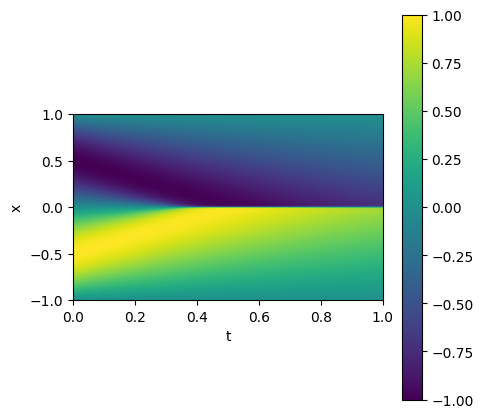

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


**Figure 1:** This is a visualization of the solution to Burger's Equation. The solution we want is one that mimics the visualization shown above using a neural network.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

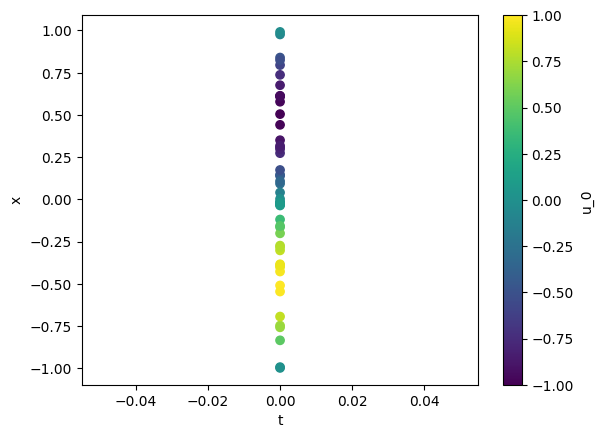

In [10]:
scatter_plot=pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
colorbar = pl.colorbar(scatter_plot)
colorbar.set_label("u_0")

**Figure 2:** This is a visualization of the initial condition for the output x when t=0. The boundaries for x are from -1 to 1. The colorbar is representative of u which is the fluid velocity.

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754,  1.        ],
       [ 0.12354946, -1.        ],
       [ 0.7718717 ,  1.        ],
       [ 0.6850728 ,  1.        ],
       [ 0.6442598 ,  1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556, -1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694,  1.        ],
       [ 0.43658102, -1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 , -1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843,  1.        ],
       [ 0.3243779 , -1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174, -1.        ],
       [ 0.77731085, -1.        ],
       [ 0.899588  , -1.        ],
       [ 0.50426483,  1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 , -1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

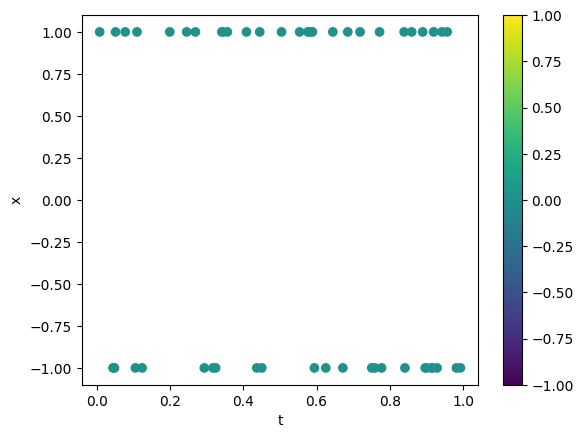

In [13]:
scatter_plot2=pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
pl.colorbar(scatter_plot2)

**Figure 3:** These are predictions for x=-1 and x=1. These are the bounds, and so we want the fluid velocity u to be 0. The color from the colorbar for each point shows u=0, so our predictions appear to be accurate.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

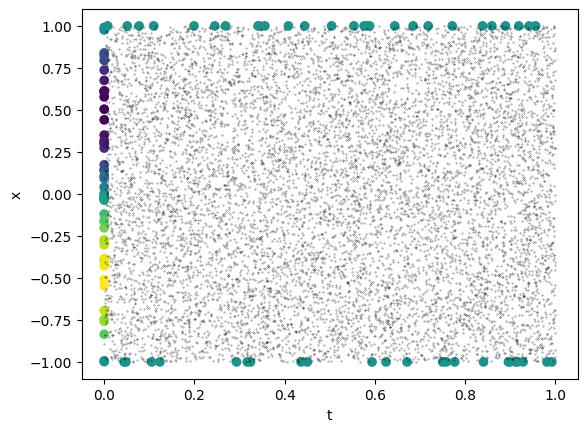

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 4: ** This is a plot of the boundary conditions and initial condition discussed in Figures 2 and 3, as well as the 10000 predicted points generated from the neural network.

In [16]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [17]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation='tanh'))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))


In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data-u_pred))

In [19]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [20]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 13s 16ms/step - loss: 0.2144
Epoch 2/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1844
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.1863
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.1796
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1776
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1745
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1703
Epoch 8/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1732
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1740
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1620
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1575
Epoch 12/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1523
Epoch 13/1000
4/4 [=========================

Text(0, 0.5, 'loss')

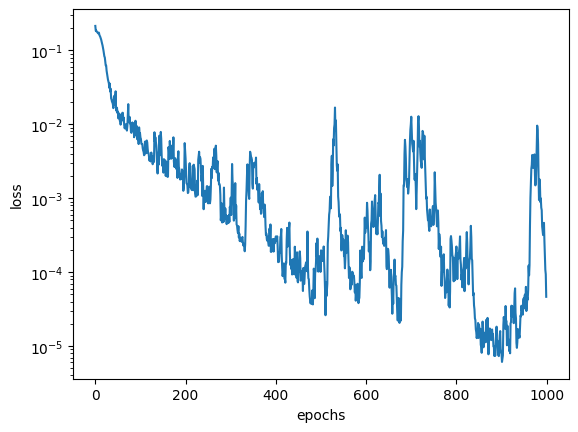

In [21]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 5:** This is the loss plotted over 1000 epochs, and the loss appears very noisy as one can see from the various spikes in the graph. This is because we are missing the Partial Differential Equations (PDEs).

## see the result

In [22]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 2ms/step


array([[-0.02193676],
       [-0.09773407],
       [ 0.08656969],
       ...,
       [ 0.00293114],
       [ 0.2953687 ],
       [-0.63861775]], dtype=float32)

313/313 [==============================] - 1s 2ms/step


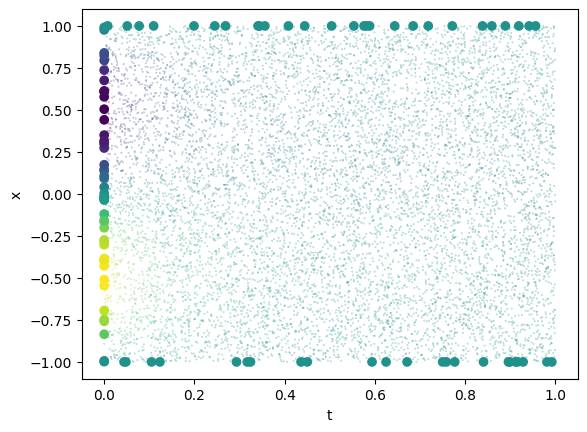

In [23]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

**Figure 6:** This is obviously not an accurate prediction, as it is predicting u=0 almost everywhere. This is because the model sees it as a good prediction since the top and bottom (the boundaries) have u=0. This is to be expected though as we have not yet given the model enough information (examples) to be accurate.

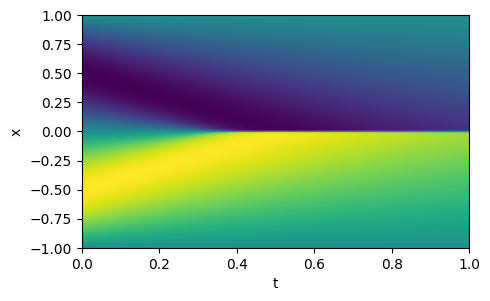

In [24]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


**Figure 1:** Shown again so it can be easily compared with Figure 6.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


-7.0494774620073635

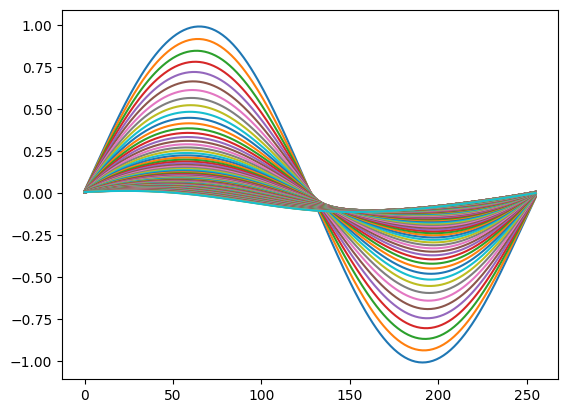

In [25]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

**Figure 7:** The horizontal axis is the elements of x (element 0 corresponds to x=-1). The vertical axis is u. Each color is a different t, and 100 t values are plotted.

8/8 [==============================] - 0s 2ms/step


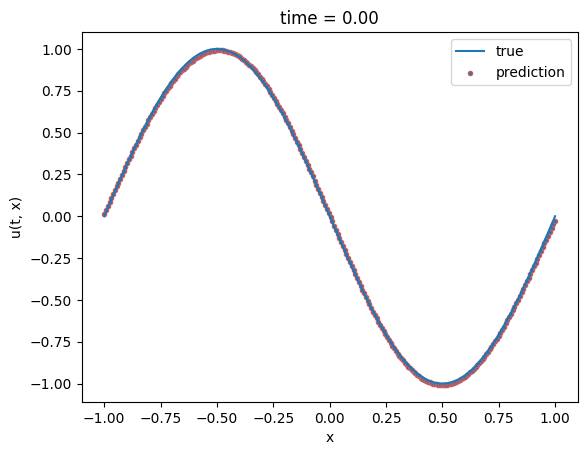

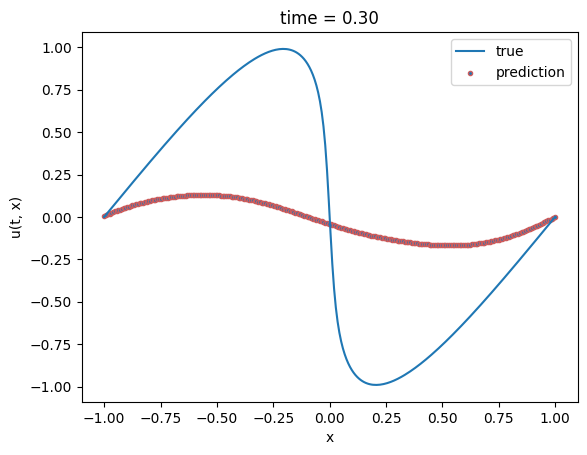

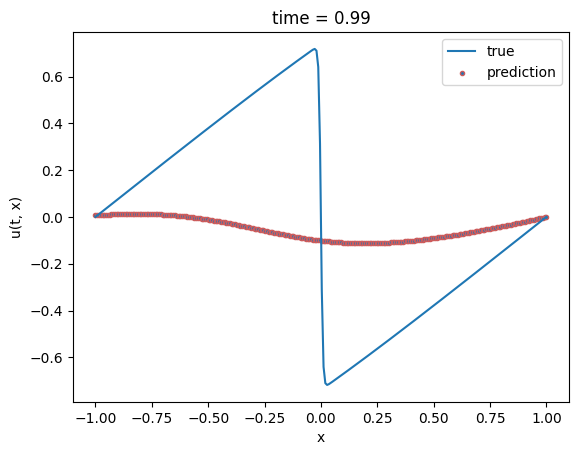

In [26]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


**Figure 8:** These are plots for the fluid velocity u given x for specific values of t. Again, we have not added the PDEs, so we expect this to be inaccurate.

Top: The plot for t=0. The prediction matches the actual data. Since we already knew the initial condition, it is expected that this be accurate already.

Middle: The plot for t=0.30. The predicted values for u are all around 0, and it is not accurately predicting the u values.

Bottom: The plot for t=0.99. Again, the predicted values are all around 0, and the neural network is not producing accurate predictions for u.

# create the model with complete loss

In [27]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [28]:
def custom_loss(model, X_r, X, y):
    u_pred = model(X)
    loss=tf.reduce_mean(tf.square(y-u_pred))
    u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
    residuals=fun_res(u_pred, u_t, u_x, u_xx)
    loss += tf.reduce_mean(tf.square(residuals))
    return loss


In [29]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables)
      loss=custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## train the model

In [30]:
import copy

In [31]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation='tanh'))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [32]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 2.72385597e-01
It 00050: loss = 1.20212555e-01
It 00100: loss = 9.23274755e-02
It 00150: loss = 7.41477981e-02
It 00200: loss = 6.27284944e-02
It 00250: loss = 5.47640510e-02
It 00300: loss = 4.66862619e-02
It 00350: loss = 5.34670055e-02
It 00400: loss = 4.44255695e-02
It 00450: loss = 3.72310095e-02
It 00500: loss = 6.90523610e-02
It 00550: loss = 5.51299527e-02
It 00600: loss = 4.22412343e-02
It 00650: loss = 2.79143937e-02
It 00700: loss = 5.63439727e-02
It 00750: loss = 3.65868807e-02
It 00800: loss = 2.12463941e-02
It 00850: loss = 4.31549288e-02
It 00900: loss = 1.94461271e-02
It 00950: loss = 2.14914102e-02
It 01000: loss = 1.19733326e-02
It 01050: loss = 3.32926735e-02
It 01100: loss = 6.31004479e-03
It 01150: loss = 3.32106603e-03
It 01200: loss = 4.97907819e-03
It 01250: loss = 2.71979906e-02
It 01300: loss = 6.63666148e-03
It 01350: loss = 2.66838446e-03
It 01400: loss = 1.94059545e-03
It 01450: loss = 1.60997920e-03
It 01500: loss = 4.14166786e-03
It 01550

313/313 [==============================] - 1s 2ms/step


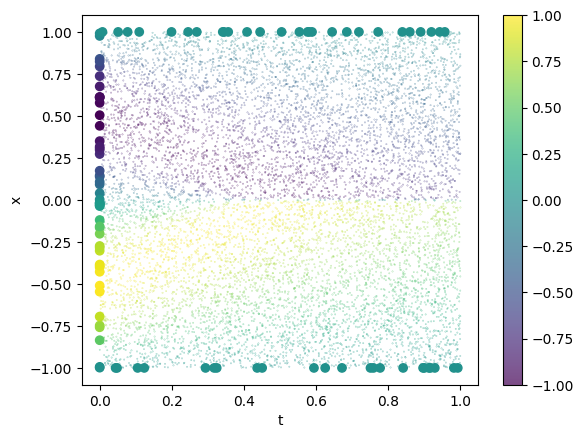

In [33]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
sp=pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.colorbar(sp)
pl.ylabel("x");

**Figure 9a:** This is the plot of the predicted u values given t. Again, similarly to Figure 6, t is on the horizontal axis and x is on the vertical one. This time, the points are much more accurately predicted. We have now added the PDEs into the neural network to predict the values of u, so we expect the model to be more accurate. This visualization was made using pl.scatter.

313/313 [==============================] - 1s 2ms/step


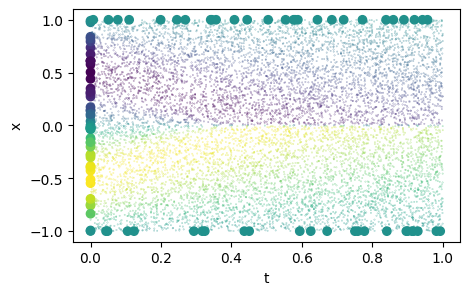

In [34]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

**Figure 9b:** The same visualization as Figure 9a but made using ax.scatter instead of pl.scatter.

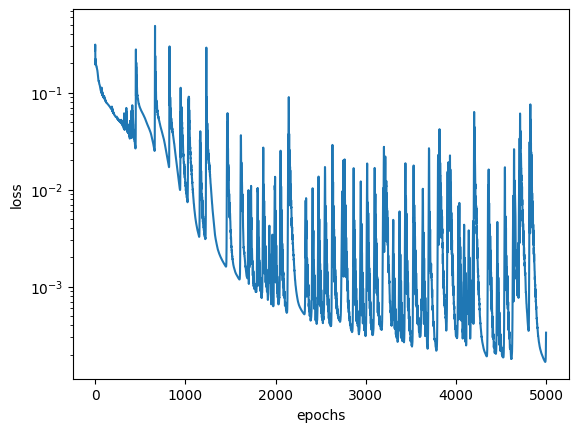

In [35]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

**Figure 10:** This graphs the loss of the new model over 5000 epochs. The loss still appears to be quite noisy.

8/8 [==============================] - 0s 3ms/step


-0.9306117476012349

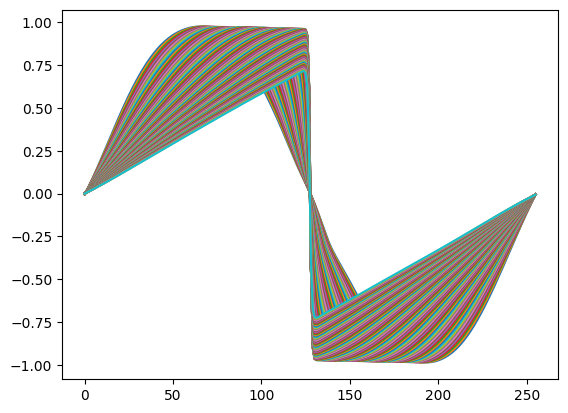

In [36]:
L1accuracy(t, x, pinn)

**Figure 11:** Just as in Figure 7, the horizontal axis is the elements of x, the vertical axis is u, and the colors are the different t values. The plot provides a visual representation of how well the model's predictions align with the truth data (z) over time.

# adjust the learning rate and trim some more
the loss was awfully noisy

In [37]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [38]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 4.78408532e-04
It 00050: loss = 1.59377320e-04
It 00100: loss = 1.58787763e-04
It 00150: loss = 1.58183509e-04
It 00200: loss = 1.57576855e-04
It 00250: loss = 1.56964947e-04
It 00300: loss = 1.56345806e-04
It 00350: loss = 1.55718852e-04
It 00400: loss = 1.55085610e-04
It 00450: loss = 1.54443987e-04
It 00500: loss = 1.53797999e-04
It 00550: loss = 1.53146771e-04
It 00600: loss = 1.52489694e-04
It 00650: loss = 1.51825254e-04
It 00700: loss = 1.51155997e-04
It 00750: loss = 1.50481646e-04
It 00800: loss = 1.49802727e-04
It 00850: loss = 1.49119485e-04
It 00900: loss = 1.48429652e-04
It 00950: loss = 1.47737723e-04
It 01000: loss = 1.47039813e-04
It 01050: loss = 1.46336897e-04
It 01100: loss = 1.45631377e-04
It 01150: loss = 1.44920850e-04
It 01200: loss = 1.44207181e-04
It 01250: loss = 1.43488447e-04
It 01300: loss = 1.42767967e-04
It 01350: loss = 1.42043733e-04
It 01400: loss = 1.41314391e-04
It 01450: loss = 1.40581644e-04
It 01500: loss = 1.39846466e-04
It 01550

Text(0, 0.5, 'loss')

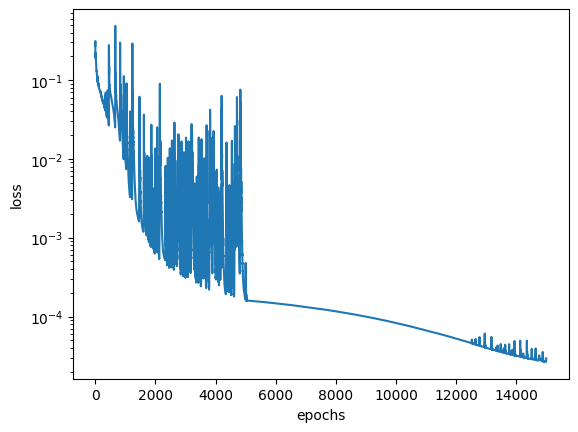

In [39]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 12:** Here we are plotting the loss over 15000 epochs. The loss still appears noisy in the beginning, but around 5000 epochs the loss seems to stabilize for the most part and there is not a lot of noise after 5000 epochs. We are slowly getting a more accurate model. Since we added more epochs, it helps with training the data more, so it makes a more accurate prediction.

313/313 [==============================] - 1s 2ms/step


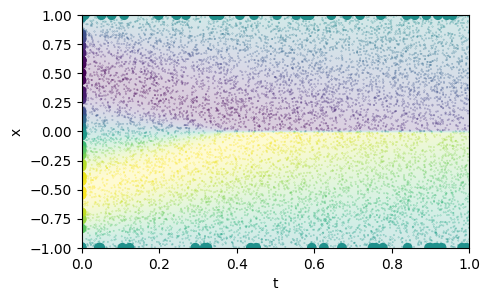

In [40]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

**Figure 13:** Figure 9 after running for 15000 epochs instead of 5000. The predictions are more accurate than in Figure 9 since the model has had more opportunity to train.

In [41]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.06404327e-05
It 00050: loss = 2.62198919e-05
It 00100: loss = 2.71857389e-05
It 00150: loss = 2.58241653e-05
It 00200: loss = 2.56108542e-05
It 00250: loss = 2.54169136e-05
It 00300: loss = 2.76567825e-05
It 00350: loss = 2.51361998e-05
It 00400: loss = 2.48319502e-05
It 00450: loss = 2.46258223e-05
It 00500: loss = 2.72525122e-05
It 00550: loss = 2.42655296e-05
It 00600: loss = 2.40863374e-05
It 00650: loss = 2.41371454e-05
It 00700: loss = 2.37399781e-05
It 00750: loss = 2.39750534e-05
It 00800: loss = 2.34078707e-05
It 00850: loss = 2.32405382e-05
It 00900: loss = 2.54690385e-05
It 00950: loss = 2.29606812e-05
It 01000: loss = 2.31539998e-05
It 01050: loss = 2.26135598e-05
It 01100: loss = 2.24713440e-05
It 01150: loss = 2.26270859e-05
It 01200: loss = 2.29408324e-05
It 01250: loss = 2.20622715e-05
It 01300: loss = 3.56082419e-05
It 01350: loss = 2.17282468e-05
It 01400: loss = 2.15850232e-05
It 01450: loss = 2.38036828e-05
It 01500: loss = 2.14620504e-05
It 01550

Text(0, 0.5, 'loss')

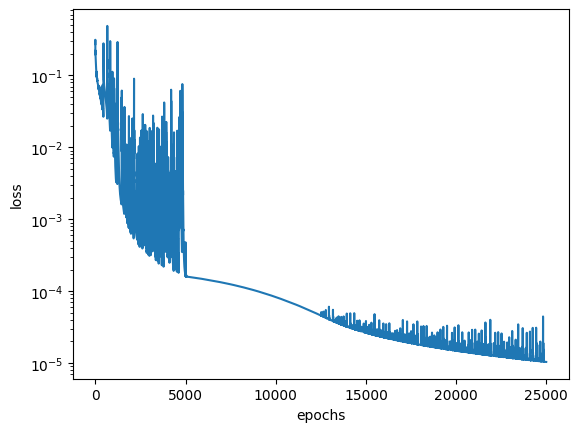

In [42]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

**Figure 14:** The loss function plotted over 25000 epochs. At this point we are overfitting and there is arguably no longer a benefit to training further. We see around 12000 epochs we start getting some noise and lose the stability we had at earlier epochs.

## final result

8/8 [==============================] - 0s 2ms/step


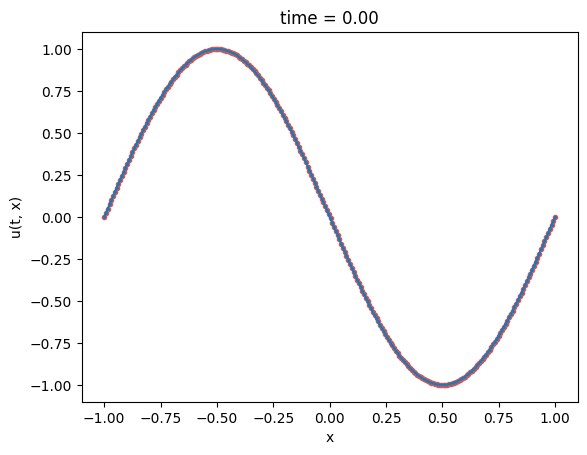

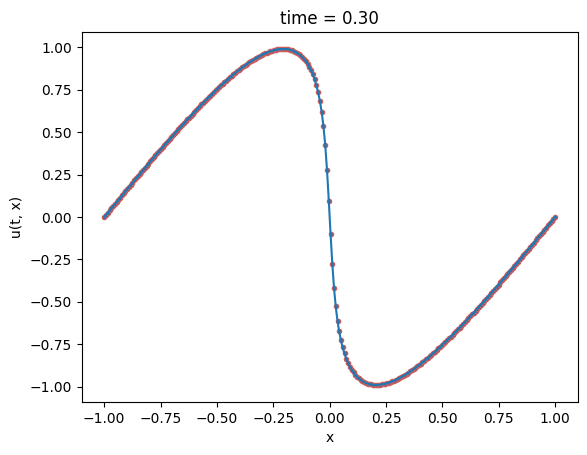

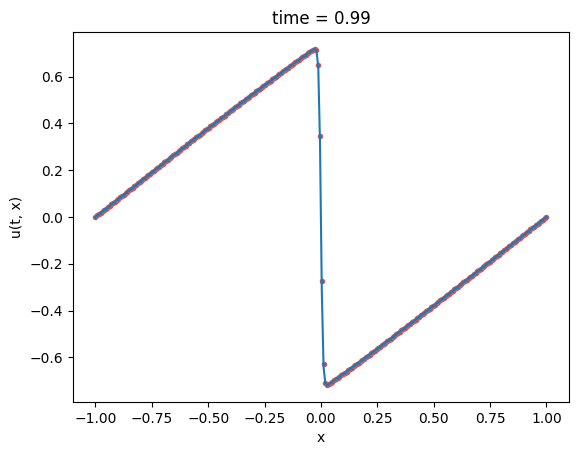

In [43]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

**Figure 15:** This is a similar visualization to Figure 8, but this is after we have run the newer model which has had more opportunity to learn the data and includes the PDEs. We can see for all the given values of t, (t=0, 0.30, and 0.99,) the predictions nearly match the actual values from Burger's Equation.

313/313 [==============================] - 1s 2ms/step


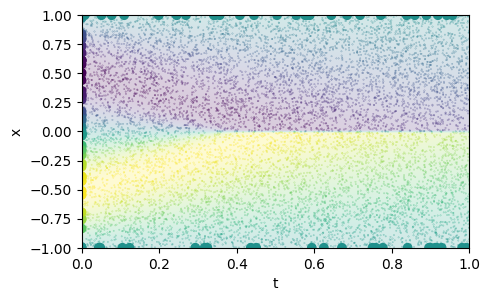

In [44]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

**Figure 16:** The true values z are in the background and the predicted points are in front. We can see the colors match up very well, meaning that the model is a good prediction for the solution of Burger's Equation.

8/8 [==============================] - 0s 2ms/step


0.12286356987415147

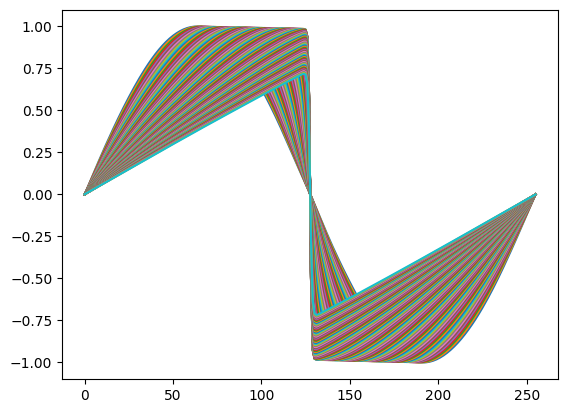

In [45]:
L1accuracy(t, x, pinn)

**Figure 17:** Just as in Figure 7 and Figure 11, the horizontal axis is the elements of x, the vertical axis is u, and the colors are the different t values. The plot provides a visual representation of how well the model's predictions align with the truth data (z) over time. This is produced from the latest model, which has had more epochs to learn the data. We also improved the learning rate.